# NS Collisions Autogluon Classification

## Introduction

Below is a data set sourced from the [Nova Scotia Data Mapping and Analytics Hub] for collisions in the Halifax Regional Municipality area (HRM) from the last 5 years (2020-2025). By using the autotabular library, the goal of this tabular model will be to predict whether collisions involving only a single vehicle were drivers from a young demographic (ages 16-24) or an older demographic (ages 24+).


[Nova Scotia Data Mapping and Analytics Hub]: https://data-hrm.hub.arcgis.com/datasets/e0293fd4721e41d7be4d7386c3c59c16_0/explore

### Importing Libraries

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

from sklearn.preprocessing import StandardScaler

### Loading Data

In [38]:
data = pd.read_csv('Nova Scotia Collisions.csv')

Before beginning, I will filter out the 'Collision Configuration' column to only rows that contain 'Single vehicle'

In [39]:
data = data[data['Collision Configuration'] == 'Single vehicle ']

<u/>Beginning DataFrame<u>

In [40]:
data

,Case File Number,Date,Time,Road Location,Intersecting Road Location,Road Configuration,Collision Configuration,Fatal_NonFatal_Injuries,Young Demographic,Pedestrian Collision,...,Light Condition,Artificial Light Condition,Weather Condition,Road Surface,Road Condition,Unusual Environmental Circumstances,Road Alignment,Road Grade,School Purpose Related,Day of Week
1,422,2020-01-02,2:55:00,205 BIRCH BEAR RUN,,Non-intersection,Single vehicle,NaN,Y,N,...,Darkness,Street lights on,Overcast or cloudy,Snow - wet,Normal,NaN,Curved,Level,NaN,Thursday
3,44,2020-01-01,5:08:00,TOWER RD,SOUTH ST,Intersection - two or more public roads,Single vehicle,Non-Fatal Injury,N,Y,...,Darkness,Street lights on,Fog,Wet,Potholes or bumps,NaN,Straight,Level,NaN,Wednesday
17,1929,2020-01-05,0:29:00,848 LUCASVILLE RD,,Non-intersection,Single vehicle,NaN,Y,N,...,Darkness,Street lights on,Overcast or cloudy,Wet,Normal,NaN,Straight,Slope,NaN,Sunday
21,2156,2020-01-05,13:08:00,BROOK ST,,Non-intersection,Single vehicle,NaN,N,N,...,Daylight,Street lights off,Snow,Snow - wet,Normal,NaN,Curved,Slope,NaN,Sunday
23,2164,2020-01-05,13:44:00,290 HIGHWAY 103,,Intersection - two or more public roads,Single vehicle,NaN,Y,N,...,Daylight,Street lights off,Snow,Snow - wet,Normal,NaN,Straight,Level,NaN,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25598,176454,2024-12-29,14:20:00,UNION ST,BEDFORD HWY,Intersection - two or more public roads,Single vehicle,Non-Fatal Injury,N,N,...,Daylight,Street lights off,Overcast or cloudy,Wet,Normal,NaN,Straight,Level,NaN,Sunday
25601,165849,2024-12-05,18:29:00,HIGHWAY 101 EB EXIT 1G HWY 102 SB RAMP,RIFLE RANGE LANE,Non-intersection,Single vehicle,NaN,N,N,...,Daylight,Unknown,Rain,Wet,Normal,NaN,Unknown,Unknown,NaN,Thursday
25603,167250,2024-12-08,15:55:00,FOREST HILLS PKWY,COLE HARBOUR RD,Intersection - two or more public roads,Single vehicle,NaN,N,N,...,Daylight,Street lights off,Snow,Snow - wet,Normal,NaN,Straight,Slope,NaN,Sunday
25614,149384,2024-10-31,0:15:00,KNIGHTSRIDGE DR,CAMELOT LANE,Non-intersection,Single vehicle,Non-Fatal Injury,N,N,...,Darkness,Street lights on,Clear,Dry - normal,Normal,NaN,Straight,Level,NaN,Thursday


### Cleaning & EDA

#### Checking for null values

In [41]:
data.isnull().sum()

Case File Number                          0
Date                                      0
Time                                      0
Road Location                             0
Intersecting Road Location                2
Road Configuration                        0
Collision Configuration                   0
Fatal_NonFatal_Injuries                4119
Young Demographic                         0
Pedestrian Collision                      0
Aggressive Driving                        0
Distracted Driving                        0
Impaired Driving                          0
Bicycle Collision                         0
Light Condition                           0
Artificial Light Condition                0
Weather Condition                         0
Road Surface                             53
Road Condition                           22
Unusual Environmental Circumstances    4407
Road Alignment                            0
Road Grade                                0
School Purpose Related          

Since there are null values present, I will fill them in with 'None' for a better analysis outcome

In [42]:
data.fillna('None', inplace = True)

#### Dropping Columns

Before changing datatypes and creating new columns from the 'Time' and 'Date' field, I will remove unnecessary columns in the dataframe for the analysis:

In [43]:
data = data.drop(columns= data[['Case File Number','Road Location','Intersecting Road Location','Unusual Environmental Circumstances','School Purpose Related', 'Road Grade','Road Alignment','Road Surface','Road Condition']])

#### Changing Data Types

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5455 entries, 1 to 25617
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        5455 non-null   object
 1   Time                        5455 non-null   object
 2   Road Configuration          5455 non-null   object
 3   Collision Configuration     5455 non-null   object
 4   Fatal_NonFatal_Injuries     5455 non-null   object
 5   Young Demographic           5455 non-null   object
 6   Pedestrian Collision        5455 non-null   object
 7   Aggressive Driving          5455 non-null   object
 8   Distracted Driving          5455 non-null   object
 9   Impaired Driving            5455 non-null   object
 10  Bicycle Collision           5455 non-null   object
 11  Light Condition             5455 non-null   object
 12  Artificial Light Condition  5455 non-null   object
 13  Weather Condition           5455 non-null   object
 

Since most of the dataframe will be text fields, I will change the text columns in to 'category' datatypes below so the analysis can properly read the data:

In [68]:
columns = [['Road Configuration','Collision Configuration','Fatal_NonFatal_Injuries','Young Demographic','Pedestrian Collision','Aggressive Driving','Distracted Driving','Impaired Driving','Bicycle Collision','Light Condition','Artificial Light Condition','Weather Condition','Day of Week']]
for cols in columns: #Above declaring the columns to be changed
    data[cols] = data[cols].astype('category') #changing the datatypes of the columns variable

##### Extracting the data from the 'Time' and 'Date' columns

Now that the text fields are set I will convert 'Time' and 'Date to a datetime column merged as one, then extract the 'Year','Month','Day','Hour','Minute', and 'Second'

In [46]:
time_format = '%H:%M:%S' #setting the time format for the dataframe to understand and convert

In [47]:
data['Date'] = pd.to_datetime(data['Date']) #Converting to a datetime type
data['Time'] = pd.to_datetime(data['Time'], format=time_format).dt.time #converting the time to a datetime type

Joining them together so we can apply dt.hour, minute, and second to the 'Time' column since it is required it is datetime for pandas to extract each unit of measure

In [48]:
data['Datetime'] = pd.to_datetime(data[['Date']].astype(str).agg('-'.join, axis=1) + ' ' + data['Time'].astype(str)) #joining the date and time columns together

Now extracting and separating each field from the 'Date' and 'Time' columns

In [49]:
data['Year'] = data['Date'].dt.year #taking the year, month, and day from the 'Date' column and creating columns of their own
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [50]:
data['Hour'] = data['Datetime'].dt.hour #taking the hours, minutes, and seconds from the 'Time' column and creating columns of their own
data['Minute'] = data['Datetime'].dt.minute
data['Second'] = data['Datetime'].dt.second

The below code is to move the new columns to the beginning of the dataframe, 'Day of Week' is currently the last column so I will include it so that all the date fields are together

In [51]:
cols = ['Year', 'Month', 'Day','Day of Week','Hour','Minute','Second'] + [col for col in data.columns if col not in ['Year', 'Month', 'Day','Day of Week','Hour','Minute','Second']]
data = data[cols] #moving these columns to the front of the dataset 

Dropping the 'Date' and 'Time' columns since we no longer need them in the dataframe

In [52]:
data = data.drop(columns=data[['Date','Time','Datetime','Second']])

Finally I will add a column called 'Collision Count' to be able to better visualize the data

In [53]:
data['Collision Count'] = 1

### Final DataFrame

#### Now that we have the final dataframe, below are the feature definitions:

+ **Year:** The year the collision took place, **dtype:** int32
- **Month:** The month the collision took place, **dtype**: int32
+ **Day:** The day the collision took place, **dtype:** int32
- **Day of Week:** The day of the week the collision took place, **dtype:** category
+ **Hour:** The hour within the day that the collision took place, **dtype:** int32
- **Minute:** The minute within the day that the collision took place, **dtype:** int32
+ **Road Configuration:** The type of road where the collision took place, **dtype:** category
- **Collision Configuration:** **Filtered out to 'Single Vehicle', the amount of vehicles involved in the accident, **dtype:** category
+ **Fatal_NonFatal_Injuries:** Whether there were no injuries, a non-fatal injury, or a fatal injury caused by the collision, **dtype:** category
- **Young_Demographic:** If the driver was ages 16-24, **dtype:** category
+ **Pedestrain Collision:** If there were pedestrians involved in the collision, **dtype:** category
- **Aggressive Driving:** If aggressive driving was an influence in the collision, **dtype:** category
+ **Distracted Driving:** If distracted driving was an influence in the collision, **dtype:** category
- **Impaired Driving:** If impaired driving was an influence in the collision, **dtype:** category
+ **Bicycle Collision:** If there was anyone riding a bicycle involved in the collision, **dtype:** category
- **Light Condition:** The time of day the collision occurred categorized by 'Darkness','Dusk','Dawn','Daylight', **dtype:** category
+ **Artificial Light Condition:** If the street lights were on or off during the collision, **dtype:** category
- **Weather Condition:** The weather conditions during the collision, **dtype:** category
+ **Collision Count:** The count for each row indicating '1' collision incident, **dtype:** int32

In [54]:
data

,Year,Month,Day,Day of Week,Hour,Minute,Road Configuration,Collision Configuration,Fatal_NonFatal_Injuries,Young Demographic,Pedestrian Collision,Aggressive Driving,Distracted Driving,Impaired Driving,Bicycle Collision,Light Condition,Artificial Light Condition,Weather Condition,Collision Count
1,2020,1,2,Thursday,2,55,Non-intersection,Single vehicle,None,Y,N,N,N,N,N,Darkness,Street lights on,Overcast or cloudy,1
3,2020,1,1,Wednesday,5,8,Intersection - two or more public roads,Single vehicle,Non-Fatal Injury,N,Y,N,N,N,N,Darkness,Street lights on,Fog,1
17,2020,1,5,Sunday,0,29,Non-intersection,Single vehicle,None,Y,N,N,N,N,N,Darkness,Street lights on,Overcast or cloudy,1
21,2020,1,5,Sunday,13,8,Non-intersection,Single vehicle,None,N,N,N,N,N,N,Daylight,Street lights off,Snow,1
23,2020,1,5,Sunday,13,44,Intersection - two or more public roads,Single vehicle,None,Y,N,Y,N,N,N,Daylight,Street lights off,Snow,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25598,2024,12,29,Sunday,14,20,Intersection - two or more public roads,Single vehicle,Non-Fatal Injury,N,N,N,N,N,N,Daylight,Street lights off,Overcast or cloudy,1
25601,2024,12,5,Thursday,18,29,Non-intersection,Single vehicle,None,N,N,N,N,N,N,Daylight,Unknown,Rain,1
25603,2024,12,8,Sunday,15,55,Intersection - two or more public roads,Single vehicle,None,N,N,N,N,N,N,Daylight,Street lights off,Snow,1
25614,2024,10,31,Thursday,0,15,Non-intersection,Single vehicle,Non-Fatal Injury,N,N,N,N,N,N,Darkness,Street lights on,Clear,1


### Visuals

Below are some visuals to gain more insight on the data:

In [55]:
data_summed_years = data.groupby('Year',observed=True)['Collision Count'].sum().reset_index() #Grouping the total collisions for each year
data_summed_vehicles = data.groupby('Road Configuration',observed=True)['Collision Count'].sum().reset_index() #Grouping the total collisions by each collision configuration
data_summed_day_sorted = data.groupby('Day of Week',observed=True)['Collision Count'].sum().reset_index() # Grouping the total collisions by young and old demographics
data_summed_light = data.groupby('Artificial Light Condition',observed=True)['Collision Count'].sum().reset_index() # Grouping the total collisions by artificial light condition

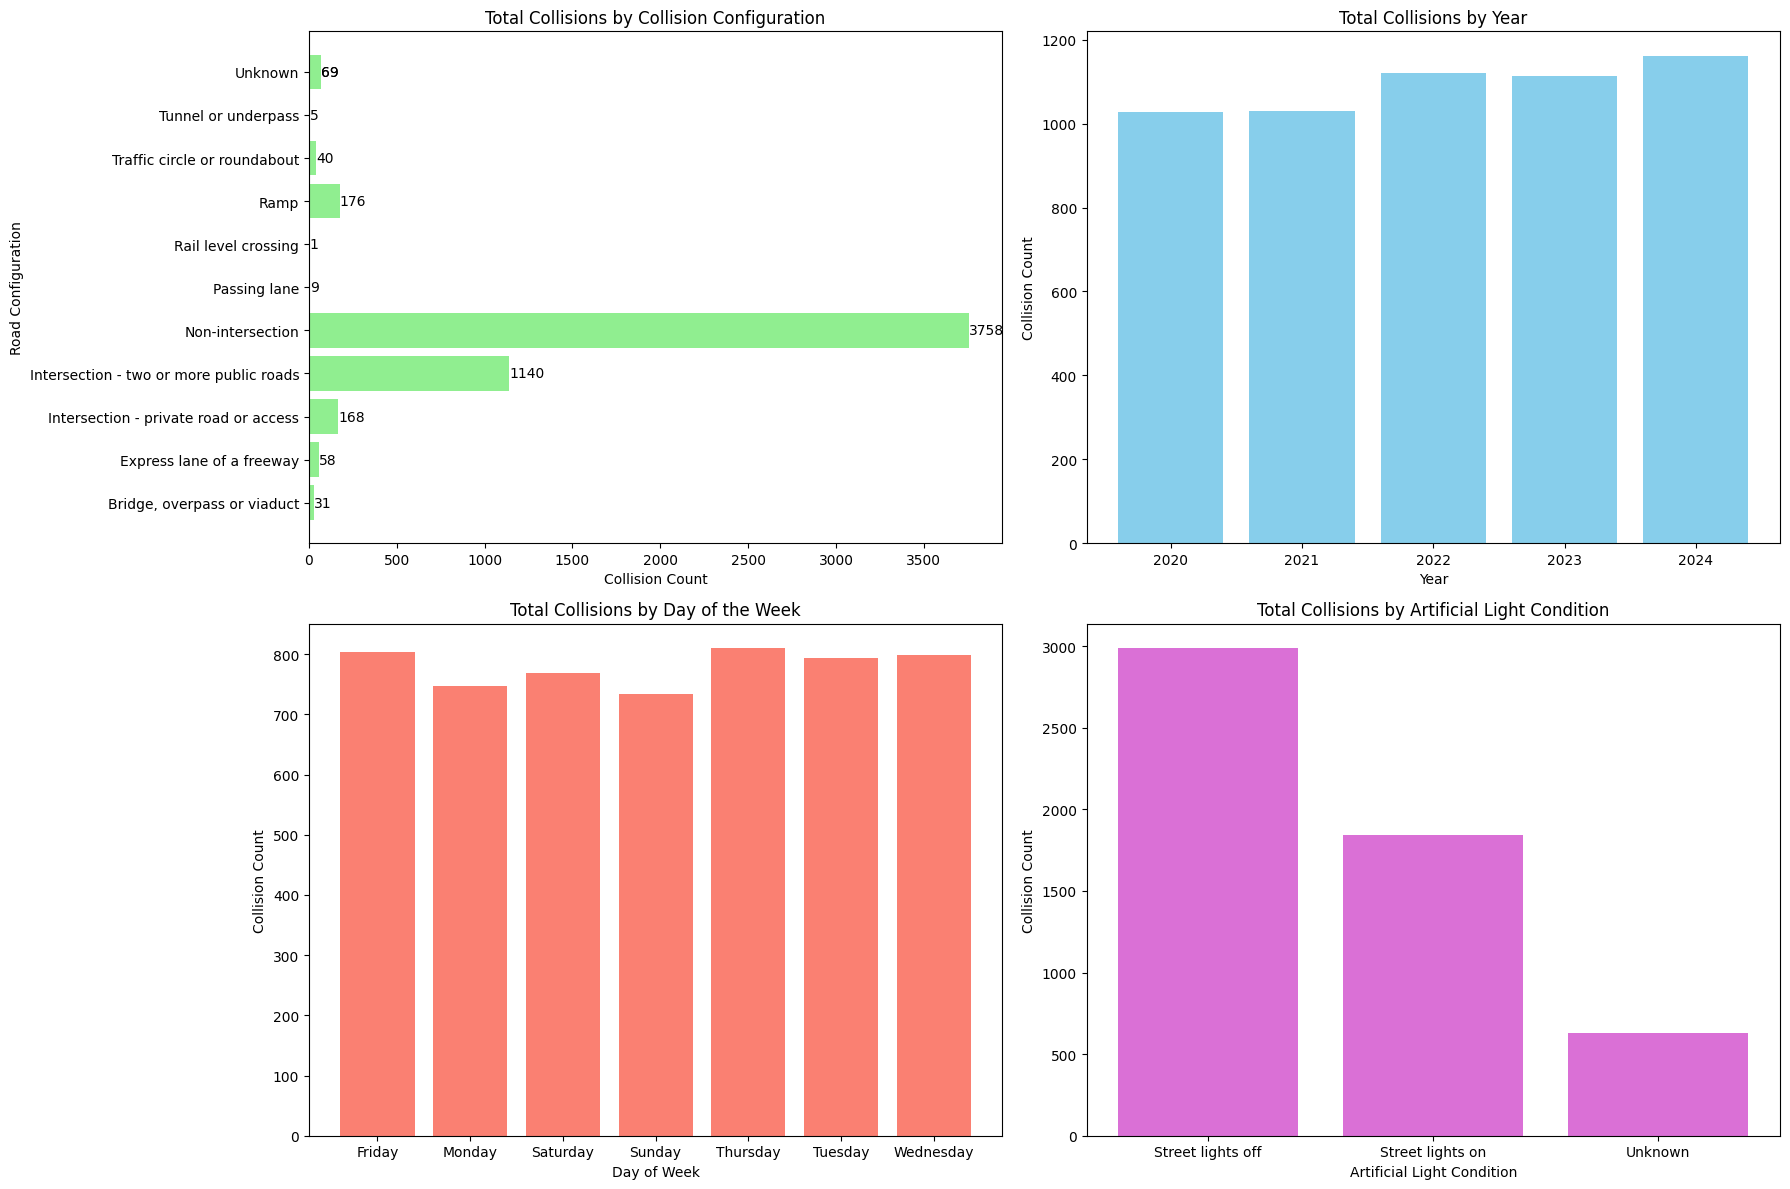

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# Plot for total tollisions by year
axes[0, 1].bar(data_summed_years['Year'], data_summed_years['Collision Count'], color='skyblue')
axes[0, 1].set_title('Total Collisions by Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Collision Count')

# Plot for total collisions by road configuration
axes[0, 0].barh(data_summed_vehicles['Road Configuration'], data_summed_vehicles['Collision Count'], color='lightgreen')
for index, value in enumerate(data_summed_vehicles['Collision Count']):
    axes[0, 0].text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')
axes[0, 0].text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')
axes[0, 0].set_title('Total Collisions by Collision Configuration')
axes[0, 0].set_xlabel('Collision Count')  
axes[0, 0].set_ylabel('Road Configuration')  

# Plot for total collisions by day of the week
axes[1, 0].bar(data_summed_day_sorted['Day of Week'], data_summed_day_sorted['Collision Count'], color='salmon')
axes[1, 0].set_title('Total Collisions by Day of the Week')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Collision Count')

# Plot for total collisions by artificial light condition
axes[1,1].bar(data_summed_light['Artificial Light Condition'], data_summed_light['Collision Count'], color='orchid')
axes[1,1].set_title('Total Collisions by Artificial Light Condition')
axes[1,1].set_xlabel('Artificial Light Condition')
axes[1,1].set_ylabel('Collision Count')
plt.tight_layout();
plt.show();

Now we can begin the analysis.

## Analysis

##### To begin I will import the necessary libraries to perform the autogluon module:

In [57]:
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor

##### 'Young Demographic' Target Values

Below are the current number of values that belong to both 'N' (Older Demographic), and 'Y' (Younger Demographic)

In [58]:
data['Young Demographic'].value_counts()

Young Demographic
N    4117
Y    1338
Name: count, dtype: int64

#### Creating the Train Test Split

Next, I will create a train test split for the autotabular predictor to read from:

In [70]:
#passing the train test split to both train_df which will be passed through the TabularPredictor, and test_df which we will compare the results to
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42, stratify=data['Young Demographic'])

#### Setting the Predictor

Below I am creating the tabular predictor to fit the training data to, the label is the target value, and the path is where the model pipeline will be stored for future use.

In [60]:
predictor = TabularPredictor(label='Young Demographic',path='collisions_class')

Now that the predictor is set we can pass the training dataframe created above through the autotabular predictor

#### Fitting Model

Using the 'predictor' model variable I created above, I will now fit the training data for the autotabular classification analysis:

In [61]:
# observe the output
predictor.fit(train_df)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.95 GB / 15.68 GB (18.8%)
Disk Space Avail:   656.08 GB / 927.56 GB (70.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accu

### Summary of Autotabular Model Results

Once the model is fitted, I can now use the model variable to create a summary of the results. You can see below that the highest score was WeightedEnsemble with a score of 76% for accuracy, followed by LightGBMXT with 75.8% accuracy while making predictions using the training data.

In [62]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.760479    accuracy       0.074576  37.892473                0.011995           0.306240            2       True         14
1            LightGBMXT   0.758483    accuracy       0.025579   1.530680                0.025579           1.530680            1       True          3
2               XGBoost   0.756487    accuracy       0.024155   1.592821                0.024155           1.592821            1       True         11
3        NeuralNetTorch   0.756487    accuracy       0.037002  36.055552                0.037002          36.055552            1       True         12
4              CatBoost   0.754491    accuracy       0.015786  44.277606                0.015786          44.277606            1       True          7
5              LightGBM   0.7544

C:\Users\coste\miniconda3\envs\tabular\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\coste\miniconda3\envs\tabular\Lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.7025948103792415,
  'KNeighborsDist': 0.7005988023952096,
  'LightGBMXT': 0.7584830339321357,
  'LightGBM': 0.7544910179640718,
  'RandomForestGini': 0.7504990019960079,
  'RandomForestEntr': 0.7465069860279441,
  'CatBoost': 0.7544910179640718,
  'ExtraTreesGini': 0.7524950099800399,
  'ExtraTreesEntr': 0.7504990019960079,
  'NeuralNetFastAI': 0.7485029940119761,
  'XGBoost': 0.7564870259481038,
  'NeuralNetTorch': 0.7564870259481038,
  'LightGBMLarge': 

### Metrics

To see all of the metrics for the model, I will now create two separate variables and compare them to one another using autotabular's evaluation feature to see how well the model did compared to the true test results of the original data.

In [71]:
y_test = test_df["Young Demographic"] #passing the test_df created in the train test split above to y_test

In [72]:
test_data = test_df.drop(columns='Young Demographic') #creating 'X' from test_df to compare to the target value and passing it to the variable test_data

In [65]:
y_pred = predictor.predict(test_data) #Passing the predictions from the test_data to y_pred

In [73]:
metrics = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True) #passing y_test to y_true, and y_pred to y_pred to compare the true dataset results to the model's predictions 
#auxiliary_metrics=True to get more metrics other than 'accuracy', 'balanced_accuracy', and 'mcc'
metrics

{'accuracy': 0.7562614538790471,
 'balanced_accuracy': 0.5079259572582432,
 'mcc': 0.07687117835698053,
 'f1': 0.03855421686746988,
 'precision': 0.6153846153846154,
 'recall': 0.01990049751243781}

### Features Importance

Below are the features contained in the dataframe, these are listed from the features that were least to most important in regards to the creation of the autotabular classification model.

In [67]:
importance = predictor.feature_importance(test_df)
importance

These features in provided data are not utilized by the predictor and will be ignored: ['Collision Configuration', 'Collision Count']
Computing feature importance via permutation shuffling for 16 features using 1637 rows with 5 shuffle sets...
	10.34s	= Expected runtime (2.07s per shuffle set)
	3.35s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Aggressive Driving,5.253513e-03,0.002098,0.002499,5,0.009574,0.000933
Road Configuration,2.076970e-03,0.001110,0.006931,5,0.004362,-0.000208
Hour,1.710446e-03,0.000796,0.004318,5,0.003350,0.000070
Light Condition,1.710446e-03,0.001458,0.029325,5,0.004713,-0.001293
Distracted Driving,1.466097e-03,0.000335,0.000304,5,0.002155,0.000777
Day of Week,1.221747e-03,0.001366,0.058058,5,0.004034,-0.001591
Minute,8.552230e-04,0.000926,0.053969,5,0.002763,-0.001052
Impaired Driving,7.330483e-04,0.000511,0.016339,5,0.001785,-0.000319
Month,6.108735e-04,0.000611,0.044505,5,0.001869,-0.000647
Pedestrian Collision,3.665241e-04,0.000697,0.152279,5,0.001801,-0.001068


## Summary

In conclusion the autotabular classification model performed decently well, with an accuracy score of 75.6% meaning the model only missed 24.4% of the values in the original data. However, the recall score is very low at 2%, meaning it seems to recognize commonly occuring cases which in this case would be the 'Older Demographic' since there are almost 4 times the amount of rows with 'N' rather than 'Y' meaning the model is missing positives ('Younger Demographic or 'Y') in the data. The F1-score also indicates that the model is unbalanced which makes sense since there is such a large gap between the value counts for both categories under 'Young Demographic'. When the model does predict 'Y', it is correct only 61.5% of the time.